In [1]:
import numpy as np
import networkx as nx
import random
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

import os
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_recall_fscore_support


In [2]:
class Graph():
    def __init__(self, nx_S, nx_A, is_directed_struc, is_directed_attr, p_struc, q_struc, p_attr, q_attr):
        self.G = [nx_S, nx_A]
        self.is_directed = [is_directed_struc, is_directed_attr]
        self.p = [p_struc, p_attr]
        self.q = [q_struc, q_attr]
        self.alias_nodes = [None, None]
        self.alias_edges = [None, None]
        self.trans_weight = [None, None]
        self.ct = [0, 0]

    # Modified node2vec walk for multi-layered graph with structure and content
    def node2vec_walk(self, walk_length, start_node):
        '''
        Simulate a random walk starting from start node.
        '''
        alias_nodes = self.alias_nodes
        alias_edges = self.alias_edges

        walk = [start_node]
        while len(walk) < walk_length:
            cur = walk[-1]
            # Decide the layer structure/attribute for the current node
            # taking upper as structure and lower level as attribute
            up = self.trans_weight[1][cur]
            down = self.trans_weight[0][cur]
            pu = up / (up + down)  # probability to select in structure layer
            pd = 1 - pu  # probability to select in attribute layer

            x = random.random()  # random num between 0---1
            if x < pu:  # if pu is large then more chances of Reference being selected
                ind = 0
            else:
                ind = 1
            self.ct[ind] += 1  # to get count which layer the Random walk is in.

            cur_nbrs = sorted(self.G[ind].neighbors(cur))
            if len(cur_nbrs) > 0:
                if len(walk) == 1:
                    walk.append(cur_nbrs[alias_draw(alias_nodes[ind][cur][0], alias_nodes[ind][cur][1])])
                else:
                    prev = walk[-2]
                    if (prev, cur) not in alias_edges[ind]:  # when the edge is not in other graph
                        walk.append(cur_nbrs[alias_draw(alias_nodes[ind][cur][0], alias_nodes[ind][cur][1])])
                    else:
                        e1 = alias_edges[ind][(prev, cur)][0]
                        e2 = alias_edges[ind][(prev, cur)][1]
                        tmp = alias_draw(e1, e2)
                        next = cur_nbrs[tmp]
                        walk.append(next)
            else:
                break

        return walk
    def simulate_walks(self, num_walks, walk_length):
        G = self.G[0]  # we can take any graph as we just need to find the nodes
        walks = []
        nodes = list(G.nodes())
        for walk_iter in range(num_walks):
            print('Walk iteration :: %s / %s' % (str(walk_iter + 1), str(num_walks)))
            random.shuffle(nodes)
            for node in nodes:
                walks.append(self.node2vec_walk(walk_length=walk_length, start_node=node))
            print('Walk count in Structure layer :: %s  , Attribute layer :: %s' % (str(self.ct[0]), str(self.ct[1])))
            self.ct = [0, 0]
        return walks

    def get_level_transition_weight(self, ind):
        G = self.G[ind]
        mat = nx.to_scipy_sparse_matrix(G)
        if ind == 0:
            avg = 1.0
        else:
            avg = 1.0 * np.sum(mat) / G.number_of_edges()
        if ind == 0:
            print('Threshold for structure layer :: %s' % str(avg))
        else:
            print('Threshold for attribute layer :: %s' % str(avg))
        mat = mat >= avg
        tau = np.sum(mat, axis=1)
        self.trans_weight[ind] = np.log(np.e + tau)

    def get_alias_edge(self, src, dst, ind):
        '''
        Get the alias edge setup lists for a given edge.
        '''
        G = self.G[ind]
        p = self.p[ind]
        q = self.q[ind]

        unnormalized_probs = []
        for dst_nbr in sorted(G.neighbors(dst)):
            if dst_nbr == src:
                unnormalized_probs.append(G[dst][dst_nbr]['weight'] / p)
            elif G.has_edge(dst_nbr, src):
                unnormalized_probs.append(G[dst][dst_nbr]['weight'])
            else:
                unnormalized_probs.append(G[dst][dst_nbr]['weight'] / q)
        norm_const = sum(unnormalized_probs)
        normalized_probs = [float(u_prob) / norm_const for u_prob in unnormalized_probs]

        return alias_setup(normalized_probs)

    def preprocess_transition_probs(self, ind):
        '''
        Preprocessing of transition probabilities for guiding the random walks.
        '''
        G = self.G[ind]
        is_directed = self.is_directed[ind]

        alias_nodes = {}
        for node in G.nodes():
            unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
            norm_const = sum(unnormalized_probs)
            normalized_probs = [float(u_prob) / norm_const for u_prob in unnormalized_probs]
            alias_nodes[node] = alias_setup(normalized_probs)

        alias_edges = {}
        triads = {}

        if is_directed:
            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1], ind)
        else:
            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1], ind)
                alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0], ind)

        self.alias_nodes[ind] = alias_nodes
        self.alias_edges[ind] = alias_edges

        return


In [3]:
def alias_setup(probs):
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int)

    smaller = []
    larger = []
    for kk, prob in enumerate(probs):
        q[kk] = K * prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q


In [4]:
def alias_draw(J, q):
    '''
    Draw sample from a non-uniform discrete distribution using alias sampling.
    '''
    K = len(J)
    kk = int(np.floor(np.random.rand() * K))
    tmp = q[kk]
    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]

In [5]:
nx_S = nx.read_edgelist("cora_struc.edgelist", nodetype=int, create_using=nx.DiGraph())
for edge in nx_S.edges():
    nx_S[edge[0]][edge[1]]['weight'] = 1
    
nx_A = nx.read_edgelist("cora_attr.edgelist", nodetype=int, data=(('weight', float),), create_using=nx.DiGraph())

In [6]:
G = Graph(nx_S, nx_A, False, False, 1, 1, 1,1)

In [7]:
assert len(nx_S.nodes()) == len(nx_A.nodes())
print("Number of nodes in the graph : %s" % len(nx_S.nodes()))
print("Number of edges in the structure graph : %s" % len(nx_S.edges()))
print("Number of edges in the attribute graph : %s" % len(nx_A.edges()))

Number of nodes in the graph : 2708
Number of edges in the structure graph : 5429
Number of edges in the attribute graph : 10832


In [8]:
def generate_walks(G, start=False):
    #################################
    # Calculate transition probabilities for switching the levels
    print('\nStructure layer trans-prob evaluation started')
    G.get_level_transition_weight(0)
    print('\nAttribute layer trans-prob evaluation started')
    G.get_level_transition_weight(1)

    # print('\nalias 1 started')
    G.preprocess_transition_probs(0)
    # print('\nalias 2 started')
    G.preprocess_transition_probs(1)

    print('\nWalk simulation started')
    walks = G.simulate_walks(10,80)
    return walks

In [9]:
G.get_level_transition_weight(0)
G.get_level_transition_weight(1)
G.preprocess_transition_probs(0)
G.preprocess_transition_probs(1)
walk = G.simulate_walks(15, 50) # parameters number of walks and walk length
walks = [list(map(str, walk)) for walk in generate_walks(G,start = True)]
#model = Word2Vec(walks, embedding_dim=128, window=10, min_count=0, sg=1, workers=8, iter=1)
model = Word2Vec(sentences=walks, vector_size=256, window=10, min_count=0, workers=8)
model.save("cora.emb")
    

Threshold for structure layer :: 1.0
Threshold for attribute layer :: 0.021923009617098654
Walk iteration :: 1 / 15
Walk count in Structure layer :: 13696  , Attribute layer :: 15702
Walk iteration :: 2 / 15
Walk count in Structure layer :: 13255  , Attribute layer :: 14818
Walk iteration :: 3 / 15
Walk count in Structure layer :: 13728  , Attribute layer :: 15094
Walk iteration :: 4 / 15
Walk count in Structure layer :: 13419  , Attribute layer :: 14928
Walk iteration :: 5 / 15
Walk count in Structure layer :: 13601  , Attribute layer :: 15573
Walk iteration :: 6 / 15
Walk count in Structure layer :: 13786  , Attribute layer :: 15453
Walk iteration :: 7 / 15
Walk count in Structure layer :: 13149  , Attribute layer :: 14931
Walk iteration :: 8 / 15
Walk count in Structure layer :: 13533  , Attribute layer :: 15326
Walk iteration :: 9 / 15
Walk count in Structure layer :: 13356  , Attribute layer :: 15233
Walk iteration :: 10 / 15
Walk count in Structure layer :: 13472  , Attribute lay

In [10]:
model = Word2Vec.load("cora.emb")

In [11]:
model.wv["192"].shape

(256,)

In [12]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
subject = "subject"
subject_as_feature = True
nodes_dtype = str
if subject_as_feature:
    feature_names.append(subject)
    column_names = feature_names
else:
    column_names = feature_names + [subject]
node_data = pd.read_csv("cora.content", sep="\t", header=None, names=column_names, dtype={0: nodes_dtype})
node_subjects = node_data[subject]

In [13]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = node_subjects[[int(node_id) for node_id in node_ids]]

In [14]:
from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, vector_size=64, window=5, min_count=0, sg=1, workers=2)

In [15]:
# The embedding vectors can be retrieved from model.wv using the node ID as key.
model.wv["31"].shape

(64,)

In [16]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = node_subjects[[int(node_id) for node_id in node_ids]]


In [17]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

Text(0.5, 1.0, 'Node visualization of CORA Dataset')

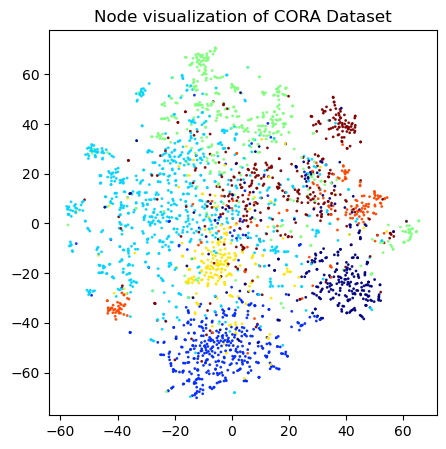

In [18]:
# draw the points
alpha = 0.9
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(5,5))
# plt.scatter(longs, lats, color = str(platformColors[platform]), zorder = 2, s = 20, marker = 'o')
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    s = 1,
    cmap="jet",
    alpha=alpha,
)
plt.title('Node visualization of CORA Dataset')

In [19]:
# X will hold the 128-dimensional input features
X = node_embeddings
# y holds the corresponding target values
y = np.array(node_targets)

In [20]:
df = pd.DataFrame({'label':y})
df['label'] = df['label'].map( {'Case_Based':0 ,'Genetic_Algorithms':1,'Neural_Networks':2,'Probabilistic_Methods':3,'Reinforcement_Learning':4,'Rule_Learning':5,'Theory':6} )

In [21]:
df['label'].isna().sum()

0

In [22]:
y = df['label'].values.tolist()


# Node Classification Logistic Regression

Array shapes:
 X_train = 270
 y_train = 270
 X_test = 2438
 y_test = 2438
micro F1 score =  0.6689909762100082
macro F1 score =  0.6431741773918144
Accuracy =  0.6689909762100082
Array shapes:
 X_train = 541
 y_train = 541
 X_test = 2167
 y_test = 2167
micro F1 score =  0.689893862482695
macro F1 score =  0.6729675499909519
Accuracy =  0.689893862482695
Array shapes:
 X_train = 812
 y_train = 812
 X_test = 1896
 y_test = 1896
micro F1 score =  0.7151898734177216
macro F1 score =  0.698927367463565
Accuracy =  0.7151898734177216
Array shapes:
 X_train = 1083
 y_train = 1083
 X_test = 1625
 y_test = 1625
micro F1 score =  0.7316923076923078
macro F1 score =  0.7089414010761512
Accuracy =  0.7316923076923076
Array shapes:
 X_train = 1354
 y_train = 1354
 X_test = 1354
 y_test = 1354
micro F1 score =  0.738552437223043
macro F1 score =  0.7171947381303007
Accuracy =  0.7385524372230429
Array shapes:
 X_train = 1624
 y_train = 1624
 X_test = 1084
 y_test = 1084
micro F1 score =  0.768450184

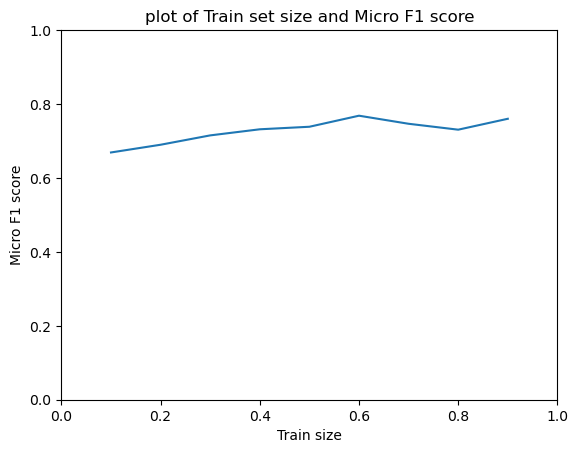

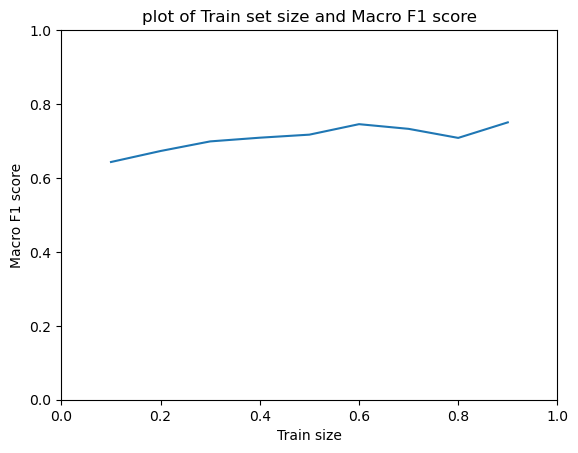

In [23]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

train_size = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
test_size = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
microf1 = []
macrof1 = []
accuracy = []
for i in range(len(train_size)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size[i], test_size=test_size[i])
    print("Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        len(X_train), len(y_train), len(X_test), len(y_test)))
    clf = LogisticRegressionCV(Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300)
    
    #clf = RandomForestClassifier(n_estimators = 100)  
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    microf1.append(f1_micro)
    macrof1.append(f1_macro)
    accuracy.append(accuracy_score(y_test, y_pred))
    print("micro F1 score = ",f1_micro)
    print("macro F1 score = ",f1_macro)
    print("Accuracy = ",accuracy_score(y_test, y_pred))
print(macrof1)
plt.plot(train_size, microf1)
plt.xlabel('Train size')
plt.ylabel('Micro F1 score')
plt.xlim(0, 1)
plt.ylim(0,1)
plt.title('plot of Train set size and Micro F1 score')
plt.show()
plt.plot(train_size, macrof1)
plt.xlabel('Train size')
plt.ylabel('Macro F1 score')
plt.xlim(0, 1)
plt.ylim(0,1)
plt.title('plot of Train set size and Macro F1 score')
plt.show()

# Node Classfication K nearest neighbour

Array shapes:
 X_train = 270
 y_train = 270
 X_test = 2438
 y_test = 2438
micro F1 score =  0.6562756357670222
macro F1 score =  0.6280841880817122
Accuracy =  0.6562756357670222
Array shapes:
 X_train = 541
 y_train = 541
 X_test = 2167
 y_test = 2167
micro F1 score =  0.6811259806183664
macro F1 score =  0.6558293931653113
Accuracy =  0.6811259806183664
Array shapes:
 X_train = 812
 y_train = 812
 X_test = 1896
 y_test = 1896
micro F1 score =  0.7109704641350211
macro F1 score =  0.6901375789228104
Accuracy =  0.7109704641350211
Array shapes:
 X_train = 1083
 y_train = 1083
 X_test = 1625
 y_test = 1625
micro F1 score =  0.7403076923076924
macro F1 score =  0.7174370640006982
Accuracy =  0.7403076923076923
Array shapes:
 X_train = 1354
 y_train = 1354
 X_test = 1354
 y_test = 1354
micro F1 score =  0.7378138847858198
macro F1 score =  0.7185259434222179
Accuracy =  0.7378138847858198
Array shapes:
 X_train = 1624
 y_train = 1624
 X_test = 1084
 y_test = 1084
micro F1 score =  0.73062

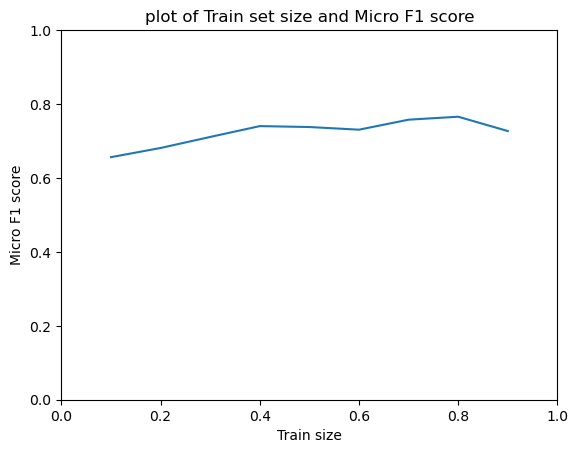

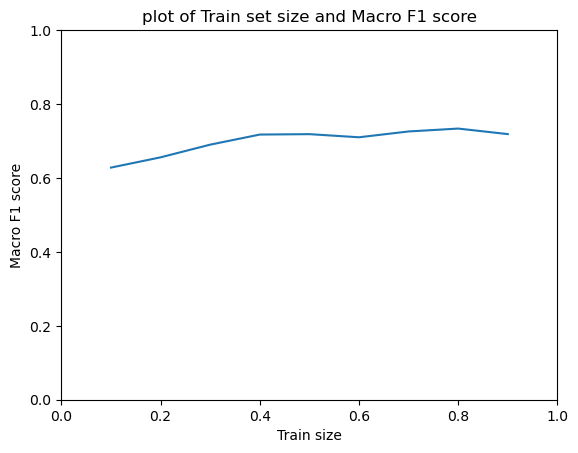

In [24]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier

train_size = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
test_size = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
microf1 = []
macrof1 = []
accuracy = []
for i in range(len(train_size)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size[i], test_size=test_size[i])
    print("Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        len(X_train), len(y_train), len(X_test), len(y_test)))
    #clf = LogisticRegressionCV(Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300)
    
    #clf = RandomForestClassifier(n_estimators = 100)
    clf = KNeighborsClassifier(n_neighbors=7)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    microf1.append(f1_micro)
    macrof1.append(f1_macro)
    accuracy.append(accuracy_score(y_test, y_pred))
    print("micro F1 score = ",f1_micro)
    print("macro F1 score = ",f1_macro)
    print("Accuracy = ",accuracy_score(y_test, y_pred))
print(macrof1)
plt.plot(train_size, microf1)
plt.xlabel('Train size')
plt.ylabel('Micro F1 score')
plt.xlim(0, 1)
plt.ylim(0,1)
plt.title('plot of Train set size and Micro F1 score')
plt.show()
plt.plot(train_size, macrof1)
plt.xlabel('Train size')
plt.ylabel('Macro F1 score')
plt.xlim(0, 1)
plt.ylim(0,1)
plt.title('plot of Train set size and Macro F1 score')
plt.show()

# Node Classification Random forest

Array shapes:
 X_train = 270
 y_train = 270
 X_test = 2438
 y_test = 2438
micro F1 score =  0.6386382280557834
macro F1 score =  0.5822868173029571
Accuracy =  0.6386382280557834
Array shapes:
 X_train = 541
 y_train = 541
 X_test = 2167
 y_test = 2167
micro F1 score =  0.7023534840793724
macro F1 score =  0.6620215918666271
Accuracy =  0.7023534840793724
Array shapes:
 X_train = 812
 y_train = 812
 X_test = 1896
 y_test = 1896
micro F1 score =  0.7315400843881856
macro F1 score =  0.6985066911732697
Accuracy =  0.7315400843881856
Array shapes:
 X_train = 1083
 y_train = 1083
 X_test = 1625
 y_test = 1625
micro F1 score =  0.7409230769230769
macro F1 score =  0.7153693721510752
Accuracy =  0.7409230769230769
Array shapes:
 X_train = 1354
 y_train = 1354
 X_test = 1354
 y_test = 1354
micro F1 score =  0.7370753323485968
macro F1 score =  0.7132217375276094
Accuracy =  0.7370753323485968
Array shapes:
 X_train = 1624
 y_train = 1624
 X_test = 1084
 y_test = 1084
micro F1 score =  0.76291

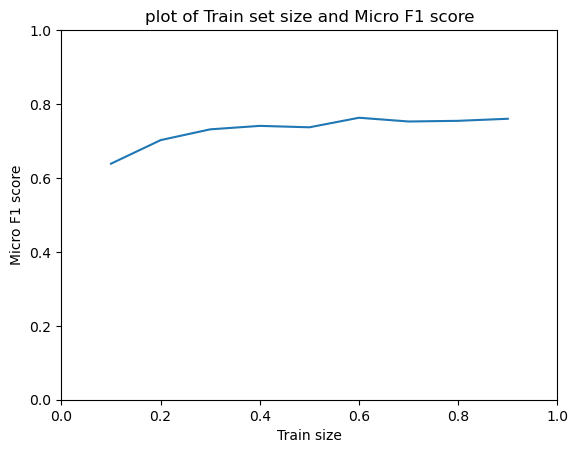

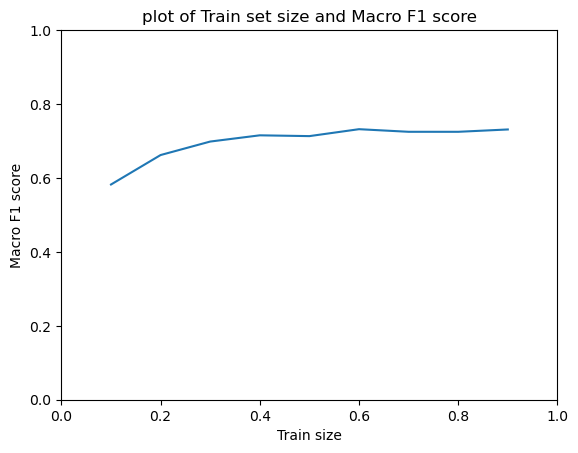

In [25]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

train_size = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
test_size = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
microf1 = []
macrof1 = []
accuracy = []
for i in range(len(train_size)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size[i], test_size=test_size[i])
    print("Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        len(X_train), len(y_train), len(X_test), len(y_test)))
    #clf = LogisticRegressionCV(Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300)
    
    clf = RandomForestClassifier(n_estimators = 100)  
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    microf1.append(f1_micro)
    macrof1.append(f1_macro)
    accuracy.append(accuracy_score(y_test, y_pred))
    print("micro F1 score = ",f1_micro)
    print("macro F1 score = ",f1_macro)
    print("Accuracy = ",accuracy_score(y_test, y_pred))
print(macrof1)
plt.plot(train_size, microf1)
plt.xlabel('Train size')
plt.ylabel('Micro F1 score')
plt.xlim(0, 1)
plt.ylim(0,1)
plt.title('plot of Train set size and Micro F1 score')
plt.show()
plt.plot(train_size, macrof1)
plt.xlabel('Train size')
plt.ylabel('Macro F1 score')
plt.xlim(0, 1)
plt.ylim(0,1)
plt.title('plot of Train set size and Macro F1 score')
plt.show()   

In [26]:
macrof1

[0.5822868173029571,
 0.6620215918666271,
 0.6985066911732697,
 0.7153693721510752,
 0.7132217375276094,
 0.7319618755740219,
 0.7249097110519711,
 0.7248882266743198,
 0.7312132312132311]

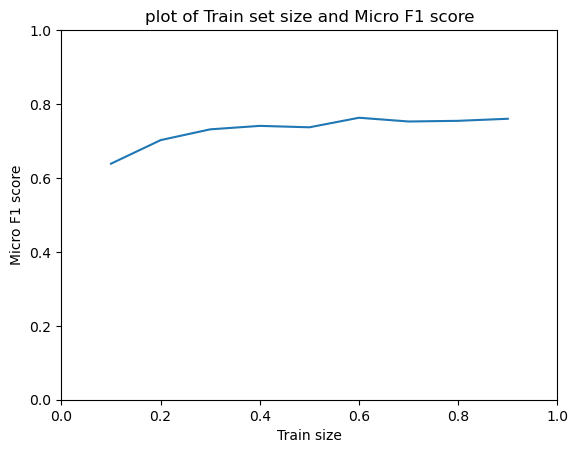

In [27]:
plt.plot(train_size, microf1)
plt.xlabel('Train size')
plt.ylabel('Micro F1 score')
plt.xlim(0, 1)
plt.ylim(0,1)
plt.title('plot of Train set size and Micro F1 score')
plt.show()

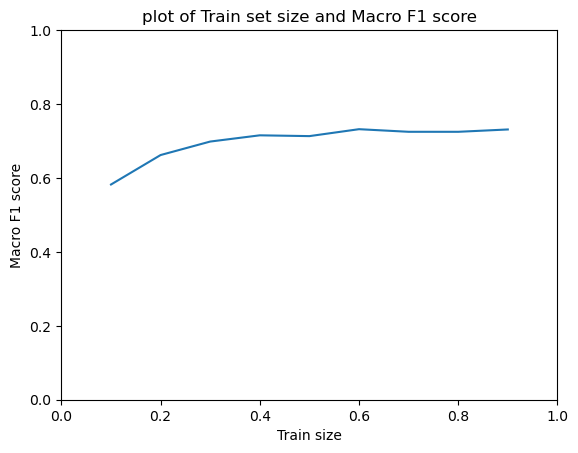

In [28]:
plt.plot(train_size, macrof1)
plt.xlabel('Train size')
plt.ylabel('Macro F1 score')
plt.xlim(0, 1)
plt.ylim(0,1)
plt.title('plot of Train set size and Macro F1 score')
plt.show()

# Node clustering Kmeans

In [46]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
node_embeddings = model.wv
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score


# Step 3: Data Preprocessing (if needed)
# You can perform normalization, scaling, or other preprocessing on node_vectors as needed

# Step 4: K-means Clustering
k = 7  # Number of clusters
node_vectors = node_embeddings.vectors
kmeans = KMeans(n_clusters=k)
kmeans.fit(node_vectors)
cluster_labels = kmeans.labels_

# Compute Silhouette Score and Davies-Bouldin Index
silhouette_avg = silhouette_score(node_vectors, cluster_labels)
davies_bouldin_index = davies_bouldin_score(node_vectors, cluster_labels)

print("Silhouette Score: ", silhouette_avg)
print("Davies-Bouldin Index: ", davies_bouldin_index)

Silhouette Score:  0.07465283
Davies-Bouldin Index:  2.687413428548195


# Node clustering spectral clustering

In [47]:
import numpy as np
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
node_embeddings = model.wv
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
# Step 4: K-means Clustering
k = 7  # Number of clusters
node_vectors = node_embeddings.vectors
spectral_clustering = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', n_neighbors=10)
spectral_clustering.fit(X)
cluster_labels = spectral_clustering.labels_
# Compute Silhouette Score and Davies-Bouldin Index
silhouette_avg = silhouette_score(node_vectors, cluster_labels)
davies_bouldin_index = davies_bouldin_score(node_vectors, cluster_labels)

print("Silhouette Score: ", silhouette_avg)
print("Davies-Bouldin Index: ", davies_bouldin_index)

Silhouette Score:  0.06718663
Davies-Bouldin Index:  2.0043376234530976
